In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from torchvision import models, transforms, datasets
from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.manual_seed(42)

def train(train_loader, val_loader):

    loss_log = []
    accuracy_log = []
    val_loss_log = []
    val_acc_log = []

    print('Training started:')
    for epoch in range(num_epochs):
        correct_predictions = 0
        total_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            predicted = torch.argmax(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_loss += loss.item()


        accuracy = correct_predictions / (len(train_loader)*train_loader.batch_size)
        loss = total_loss/ len(train_loader)

        if val_loader:
            vl, va = test(val_loader)
            val_loss_log.append(vl)
            val_acc_log.append(va)
        else:
            vl, va = 0, 0

        accuracy_log.append(accuracy)
        loss_log.append(loss)
        print(f'\tEpoch [{epoch + 1}/{num_epochs}] -> Loss: {loss:.2f}, Accuracy: {accuracy*100:.2f}% | Validation -> Loss: {vl:.2f}, Accuracy: {va*100:.2f}%')

    print('Training ended.')
    return loss_log, accuracy_log, val_loss_log, val_acc_log

def test(test_loader, pm=False, confusion_mat=False):
    model.eval()
    test_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    y_labels = torch.tensor([])
    y_predictions = torch.tensor([])
    y_labels, y_predictions = y_labels.to(device), y_predictions.to(device)

    with torch.no_grad():
      for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            predicted = torch.argmax(outputs, 1)
            if confusion_mat:
                y_predictions = torch.concat( [y_predictions, predicted], dim=0)
                y_labels = torch.concat([y_labels, labels], dim=0)

            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)


    accuracy = correct_predictions / total_samples
    test_loss /= len(test_loader)
    if pm:
        print(f'Test Loss: {test_loss:.4f}, Accuracy: {accuracy * 100:.2f}%')

    if not confusion_mat:
      return test_loss, accuracy
    cm = confusion_matrix(y_true=y_labels.cpu(), y_pred=y_predictions.cpu())
    return test_loss, accuracy, cm

def plot_train(loss, acc, vloss, vacc):
    if not vloss:
        vloss = [0]
        vacc = [0]
    _, axs = plt.subplots(2, 1, figsize=(8, 8))
    axs[0].plot(loss, label='Loss', marker='o', color='orange')
    axs[1].plot(acc, label='Accuracy', marker='x', color='blue')
    axs[0].plot(vloss, label='Validation Loss', marker='s', color='green')
    axs[1].plot(vacc, label='Validation Accuracy', marker='^', color='red')
    axs[0].legend()
    axs[1].legend()
    axs[0].set_xlabel('Epoch')
    axs[1].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[1].set_ylabel('Accuracy')
    text_box = f'Final values:\nLoss: {loss[-1]:.4f}\nAccuracy: {acc[-1]:.4f}\nValidation Loss: {vloss[-1]:.4f}\nValidation Accuracy: {vacc[-1]:.4f}'
    text_box2  = f'Best Validation Accuracy: {max(vacc):.4f}\nAt epoch: {vacc.index(max(vacc)) + 1}\nWith Loss: {vloss[vacc.index(max(vacc))]:.4f} '
    plt.text(0, -1, text_box, transform=axs[1].transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
    plt.text(0.5, -1, text_box2, transform=axs[1].transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
    plt.tight_layout()
    plt.savefig('Training.jpg')

def plot_test(loss, acc, cm):
    letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
    _, ax = plt.subplots(figsize=(8, 6))
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    plt.colorbar(cax, ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_xticks(range(num_classes))
    ax.set_yticks(range(num_classes))
    ax.set_xticklabels(letters)
    ax.set_yticklabels(letters)
    ax.set_title('Confusion Matrix')
    info_text = f"Loss: {loss:.2f}\nAccuracy: {acc:.2%}"
    ax.text(1.3, 0.5, info_text, transform=ax.transAxes, fontsize=12, verticalalignment='center')
    plt.subplots_adjust(right=0.75)
    plt.savefig('Testing.jpg')




def define_model():
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    for param in model.parameters():
      param.requires_grad = False

    inparm = model.fc.in_features
    model.fc = nn.Linear(inparm, num_classes)

    return model

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0, 0, 0], std=[255,255,255])
])


In [ ]:
on_colab = True
if not on_colab:
  root = os.getcwd()
  train_dir = os.path.join(root, 'train')
  val_dir = os.path.join(root, 'val')
  test_dir = os.path.join(root, 'test')
  save_path = os.path.join(os.getcwd(), 'asl_model.pth')

else:
  train_dir = '/content/drive/MyDrive/train'
  val_dir = '/content/drive/MyDrive/val'
  test_dir = '/content/drive/MyDrive/test'
  save_path = 'asl_model.pth'


learn_rate = 0.001
num_epochs = 5
batch_size = 32
num_classes = 26
model = define_model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learn_rate)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)
criterion.to(device)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 162MB/s]


CrossEntropyLoss()

In [ ]:
trainset = datasets.ImageFolder(root=train_dir, transform=transform)
valset = datasets.ImageFolder(root=val_dir, transform=transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=True)
testset = datasets.ImageFolder(root=test_dir, transform=transform)
test_loader = DataLoader(testset, batch_size=1, shuffle=False)

In [ ]:
from torch.utils.data import ConcatDataset
full_train_dataset = ConcatDataset([trainset, valset])
full_train_loader = DataLoader(full_train_dataset, batch_size=32, shuffle=True)

Running on: cuda
Test Loss: 0.7901, Accuracy: 79.01%


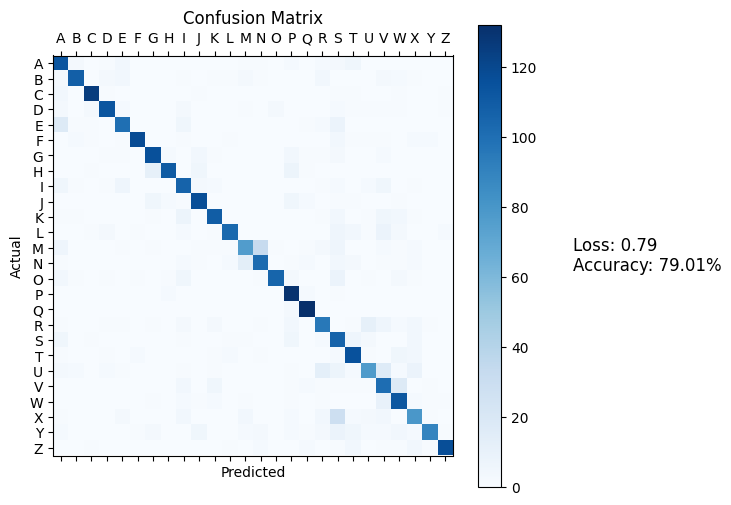

In [ ]:
train_model = False
print('Running on:', device)
if train_model:
    loss, acc, vloss, vacc = train(full_train_loader, val_loader=None)
    plot_train(loss, acc, vloss, vacc)
    torch.save(model.state_dict(), save_path)
else:
    model.load_state_dict(torch.load(save_path))
    loss, acc, cm = test(test_loader, pm=True, confusion_mat=True)
    plot_test(loss, acc, cm)
